In [1]:
import copy
import numpy as np
import numba
from numba import int64, float64, jit, njit, vectorize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
@njit
def bec_p1(x: int64[:], e: float64) -> (float64[:]):
    '''
    Transmit binary x through BEC(e) with P1 domain output

          Arguments:
                  x (int[:]): array of 0/1 channel inputs
                  e (float): channel erasure probability

          Returns:
                  y (float[:]): Numpy array of P1 values for received values
    '''
    y = np.random.random_sample(len(x))
    for i in range(len(x)):
        if (y[i]<e):
            y[i] = 0.5
        else:
            y[i] = x[i]

    return y
     
@njit
def bsc_p1(x: int64[:], p: float64) -> (float64[:]):
    '''
    Transmit binary x through BSC(p) with P1 domain output

          Arguments:
                  x (int[:]): array of 0/1 channel inputs
                  p (float): channel erasure probability

          Returns:
                  y (float[:]): Numpy array of P1 values for received values
    '''
    z = np.random.random_sample(len(x))
    y = np.zeros(len(x))+p
    for i in range(len(x)):
        if ((z[i]<p) != (x[i]==1)):
            y[i] = 1-p

    return y

@njit
def awgn_p1(x: int64[:], esno_db: float64) -> (float64[:]):
    '''
    Transmit binary x through BIAWGN(esno_db) with P1 domain output

          Arguments:
                  x (int[:]): array of 0/1 channel inputs
                  esno_db (float): channel signal energy divided by noise spctral density in dB

          Returns:
                  y (float[:]): Numpy array of P1 values for received values
    '''
    m = np.sqrt(10**(esno_db/10) * 2)
    z = np.random.normal(loc=m,scale=1,size=x.shape)
    y = 1/(1+np.exp(2*m*z))
    for i in range(len(x)):        
        if (x[i]==1):
            y[i] = 1-y[i]
            
    return y

In [3]:
# Simple tests of above functions
print(bec_p1(np.asarray([0,1,0,1,0,1,0,1],dtype=np.int),0.5))
print(bsc_p1(np.asarray([0,1,0,1,0,1,0,1],dtype=np.int),0.45))
print(awgn_p1(np.asarray([0,1,0,1,0,1,0,1],dtype=np.int),3))

[0.  0.5 0.5 1.  0.  0.5 0.  1. ]
[0.55 0.55 0.45 0.55 0.45 0.45 0.45 0.45]
[2.66719294e-03 9.99999415e-01 5.97496646e-06 9.99993652e-01
 6.01896833e-04 9.98331366e-01 1.06302401e-04 9.99981749e-01]


In [4]:
@njit
def polar_bec(n,e):
    '''
    Compute effective-channel erasure rates for polar code of length N=2^n on BEC(e)

          Arguments:
                  n (int): number of polarization stages
                  e (float): channel erasure probability

          Returns:
                  E1 (float[:]): Numpy array of floats with erasure rates of effective channels
    '''
    E1 = np.zeros(2**n)
    E2 = np.zeros(2**n)
    E1[0] = e
    m = 1
    for i in range(n):
        # Interleave updates to keep in polar decoding order
        E2[:2*m:2] = 1-(1-E1[:m])*(1-E1[:m])
        E2[1:2*m:2] = E1[:m]*E1[:m]
        E1, E2 = E2, E1
        m = m * 2
    
    return E1

In [5]:
# Compute erasure rate for polar sub channels
print(polar_bec(3,0.5))

[0.99609375 0.87890625 0.80859375 0.31640625 0.68359375 0.19140625
 0.12109375 0.00390625]


In [6]:
@njit('(int64[:])(int64[:])') # Input/output specifications to make Numba work
def polar_transform(u):
    '''
    Encode polar information vector u

          Arguments:
                  u (int64[:]): Numpy array of input bits

          Returns:
                  x (int64[:]): Numpy array of encoded bits
    '''
    # Recurse down to length 1
    if (len(u)==1):
        return u;
    else:
        # R_N maps odd/even indices (i.e., u1u2/u2) to first/second half
        # Compute odd/even outputs of (I_{N/2} \otimes G_2) transform
        x = np.zeros(len(u), dtype=np.int64)
        x[:len(u)//2] = polar_transform((u[::2]+u[1::2])%2)
        x[len(u)//2:] = polar_transform(u[1::2])
        return x

In [7]:
# Test polar transform
print(polar_transform(np.array([0,1,1,0,1,0,1,1],dtype=np.int64)))

[1 1 1 0 0 1 1 1]


In [8]:
@njit
def polar_design(biterrd,d):
    '''
    Design polar code from additive channel noise scores

          Arguments:
                  biterrd (float[:]): Numpy array of channel noise scores (e.g., error rates)
                  d (float): Sum constraint of total noise for unfrozen channels

          Returns:
                  f (float[:]): Numpy array indicating frozen bits by 0 and info bits by 0.5
    '''
    # Sort into increasing order and compute cumulative sum
    order = np.argsort(biterrd)
    SE = biterrd[order]
    CSE = np.cumsum(SE)

    # Find best frozen bits
    k = np.sum(CSE<d)
    f = np.zeros(len(biterrd))
    f[order[:k]] = 0.5
    return f

In [9]:
# Test design for polar sub channels for BEC
polar_design(polar_bec(4,0.5),0.1)

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ,
       0.5, 0.5, 0.5])

In [10]:
# Check-node operation in P1 domain
#   For two independent bits with P1 equal to w1,w2, return probability of even parity
@vectorize([float64(float64,float64)],nopython=True)
def cnop(w1,w2):
    return w1*(1-w2) + w2*(1-w1)

# Bit-node operation in P1 domain
#   For two independent P1 observations (w1,w2) a uniform bit, return P1 of the bit
@vectorize([float64(float64,float64)],nopython=True)
def vnop(w1,w2):
    return (w1*w2) / (w1*w2 + (1-w1)*(1-w2))

# Hard decision with randomized rounding in P1 domain
#   Return hard MAP decision with randomized tie breaking for P1 observation
@vectorize([int64(float64)],nopython=True)
def hard_dec_rr(w):
    return np.int64((1-np.sign(1-2*w)>2*np.random.random_sample(1)).all())

In [11]:
@njit # Input/output specifications below to make Numba work
def polar_decode(y: float64[:],f: float64[:]) -> (int64[:],int64[:]):
    '''
    Recursive succesive cancellation polar decoder from P1 observations

          Arguments:
                  y (float[:]): channel observations in output order
                  f (float[:]): input a priori probabilities in input order

          Returns:
                  u (int[:]): input hard decisions in input order
                  x (int[:]): output hard decisions in output order
    '''
    # Recurse down to length 1
    N = len(y)
    if (N==1):
        # If information bit (i.e., f=1/2 for P1 domain)
        x = hard_dec_rr(y)
        if (f[0]==1/2):
            # Make hard decision based on observation
            return x, x.copy()
        else:
            # Use frozen bit (u,x) = (f,f)
            return x, f.astype(np.int64)
    else:
        # Compute soft mapping back one stage
        u1est = cnop(y[::2],y[1::2])

        # R_N^T maps u1est to top polar code
        uhat1, u1hardprev = polar_decode(u1est,f[:(N//2)])

        # Using u1est and x1hard, we can estimate u2
        u2est = vnop(cnop(u1hardprev,y[::2]),y[1::2])

        # R_N^T maps u2est to bottom polar code
        uhat2, u2hardprev = polar_decode(u2est,f[(N//2):])
                                            
    # Pass u decisions up and interleave x1,x2 hard decisions
    #   note: Numba doesn't like np.concatenate
    u = np.zeros(N,dtype=np.int64)
    u[:(N//2)] = uhat1
    u[(N//2):] = uhat2
    x1 = cnop(u1hardprev,u2hardprev)
    x2 = u2hardprev
    x = np.zeros(N,dtype=np.int64)
    x[::2] = x1
    x[1::2] = x2

    return u, x

In [12]:
# These test cases match previous MATLAB code results
print(polar_decode(np.asarray([0.2,0.6,0.3,0.8]),np.asarray([0,1,0,0.5])))
print(polar_decode(np.asarray([0.2,0,0.3,0.8]),np.asarray([0.5,0.5,0,0.5])))
print(polar_decode(np.asarray([0.2,0.6,0.3,0.8,0.1,0.7,0.4,0.3]),np.asarray([0,1,0,0,0,0.5,0,0.5])))
print(polar_decode(np.asarray([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.9,0.1,0.1,0.1]),np.zeros(16)))

(array([0, 1, 0, 1]), array([0, 1, 0, 1]))
(array([1, 1, 1, 0]), array([0, 0, 1, 0]))
(array([1, 0, 1, 0, 1, 1, 0, 0]), array([0, 1, 0, 0, 0, 1, 0, 0]))
(array([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))


In [13]:
@njit
def polar_channel_mc(n: int64, chan, p: float64, M: int64) -> (float64[:]):
    '''
    Monte Carlo estimate of error rates for effective channels of length N=2^n polar code

          Arguments:
                  n (int): number of polarization stages
                  chan (function): function that sends bits over channel and returns P1 observations
                  p (float): parameter for channel
                  M (int): Number of blocks for Monte Carlo estimate

          Returns:
                  biterrd (float[:]): Numpy array of channel noise scores (e.g., error rates)
                  u (int[:]): input hard decisions in input order
                  x (int[:]): output hard decisions in output order
    '''
    # Setup parameters
    N = 2**n
    f = np.zeros(N)
    biterrd = np.zeros(N)

    # Monte Carlo evaluation of error probability
    x = np.zeros(N,dtype=np.int64)
    for i in range(M):
        # Transmit random codeword through channel with parameter p
        #x = np.random.randint(0,2,size=N)
        y = chan(x,p)
        #for j in range(N):
        #    if (x[j]==1):
        #        y[j] = 1 - y[j]
        
        # Decode received vector using all-zero frozen vector
        uhat, xhat = polar_decode(y,f)
        biterrd = biterrd + uhat.astype(np.float64)
        
    return biterrd/M

In [14]:
# Test polar_channel_mc for BSC
biterrd = polar_channel_mc(12,bsc_p1,0.1,2000)
f = polar_design(biterrd,0.1)
print("Rate:",2*np.mean(f))

# Test polar_channel_mc for BIAWGNC
biterrd = polar_channel_mc(12,awgn_p1,-1.25,2000)
f = polar_design(biterrd,0.1)
print("Rate:",2*np.mean(f))

Rate: 0.412353515625
Rate: 0.509765625


In [15]:
# Test polar_channel_mc for BSC and BIAWGNC
print(polar_channel_mc(4,bsc_p1,0.10,1000))
print(polar_channel_mc(4,awgn_p1,-1.25,1000))

[0.481 0.399 0.376 0.238 0.538 0.279 0.225 0.037 0.551 0.302 0.207 0.016
 0.129 0.007 0.004 0.   ]
[0.529 0.387 0.364 0.152 0.334 0.112 0.082 0.01  0.26  0.064 0.042 0.002
 0.031 0.    0.    0.   ]


In [16]:
def test_polar(n=12, chan=None, p=0.1, M=100, f=None, T=1000, d=0.1):
    '''
    Test polar code via design and simulation

          Arguments:
                  n (int): number of polarization stages
                  chan (function): function that sends bits over channel and returns P1 observations
                  p (float or float[:]): parameter(s) for simualtion channel(s)
                  M (int): Number of blocks to simulate
                  f (float[:]): Numpy vector indicating frozen bits
                  T (int): Number of blocks for Monte Carlo estimate of frozen bits using p[0] channel
                  d (float): Sum constraint of total noise for unfrozen channels

          Returns:
                  ber (float[:]): Numpy array of BER estimate for each channel parameter
                  wer (float[:]): Numpy array of WER estimate for each channel parameter
    '''  
    # Handle different calling argument styles
    if isinstance(p,float) or isinstance(p,int):
        dp = p
        p = [p]
        M = [M]
    else:
        dp = p[0]
        if isinstance(M,int):
            M = [M for i in range(len(p))]

    # Display
    N = 2**n
    print("N =",N,", chan =",chan,", p =",p, ", M =",M)

    # Design polar code
    if f is None:
        # Compute the quality of all effective channels
        print("T =",T,", dp =",dp,", d =",d)
        if chan is None:
            biterrd = polar_bec(n,dp)
        else:
            biterrd = polar_channel_mc(n,chan,dp,T)
        f = polar_design(biterrd,d)
    A = (f==1/2)
    k = np.sum(A)
    rate = k/N
    print("Rate =",rate)
            
    # Run sims to compare with union bound
    biterr = [[0,]*M[i] for i in range(len(M))]
    mlerr = [[0,]*M[i] for i in range(len(M))]
    yy = np.empty(N)

    # For each channel parameter
    for j in range(len(p)):
        # For each block
        for i in range(M[j]):
            # Set frozen bits, add random data, and encode
            u = f.astype(np.int)
            u[A] = np.random.randint(0,2,size=k)
            x = polar_transform(u);

            # Transmit
            if chan is None:
                # Use erasure channel if no channel provided
                y = bec_p1(x,p[j])
            else:
                y = chan(x,p[j])
                
            # Decode and compute error rate for info bits
            uhat, xhat = polar_decode(y,f)
            biterr[j][i] = np.mean(uhat[A] != u[A])
                
    # Display average bit and block error rate
    ber = [np.mean(biterr[j]) for j in range(len(biterr))]
    wer = [np.mean(np.asarray(biterr[j])>0) for j in range(len(biterr))] 
    print("ber =",ber)
    print("wer =",wer)
    return ber, wer

In [17]:
%%time
p=[-1.25, -0.75, -0.25]
M=[500,2000,10000]
ber, wer = test_polar(n=12, chan=awgn_p1, p=p, M=M, T=5000, d=0.1);

N = 4096 , chan = CPUDispatcher(<function awgn_p1 at 0x7fa400c8f0d0>) , p = [-1.25, -0.75, -0.25] , M = [500, 2000, 10000]
T = 5000 , dp = -1.25 , d = 0.1
Rate = 0.5087890625
ber = [0.02012380038387716, 0.0003023032629558541, 3.0326295585412667e-05]
wer = [0.104, 0.003, 0.0004]
CPU times: user 1min 55s, sys: 690 ms, total: 1min 56s
Wall time: 1min 57s


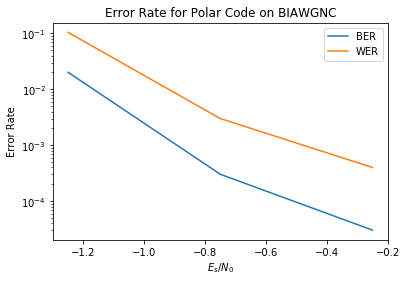

In [18]:
# Plot figure
plt.semilogy(p,ber,label="BER")
plt.semilogy(p,wer,label="WER")
plt.title("Error Rate for Polar Code on BIAWGNC")
plt.xlabel("$E_s/N_0$")
plt.ylabel("Error Rate")
plt.legend()
plt.show()